#### Hacettepe University

#### Artificial Intelligence Engineering Department

#### Name - Surname :  Mehmet Alperen Ozcelik

## Age Estimation from Face Images

In [1]:
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Hw_Data.csv', sep = ',')
print('Number of Images : {}'.format(len(df)))
df.head()

Number of Images : 900


,Name,Age
0,055A12.JPG,12.0
1,016A03.JPG,3.0
2,054A06.JPG,6.0
3,053A06.JPG,6.0
4,080A02.JPG,2.0


##### I applied the grayscale process and resized the photos I took from the file and returned the list of images and names in load_images() function.

In [3]:
def load_images(folderName):
    
    imageList = []
    nameList = []
    
    for filename in os.listdir(folderName):
        img = cv2.imread(os.path.join(folderName, filename))
        
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
            resized = cv2.resize(gray,(100,100), interpolation= cv2.INTER_LINEAR) #resize
            imageList.append(resized)
            nameList.append(filename)
                   
    imageList = np.array(imageList)
    
    return imageList, nameList

##### get the list of ages from images name list

In [4]:
images,names =  load_images('assignment_images')

ages = []
for i in names:
    ages.append(int(i[4:6]))

##### I used roberts and sobel edge detections in my predictions. Thanks to this function, my imagelist, in which I put normal pictures, undergoes the roberts and sobel edge detection process and returns 2 lists.

In [5]:
from skimage import filters

def edge_detectors(images):
    
    edge_roberts = []
    edge_sobel = []

    for i in images:

        edge_roberts.append(filters.roberts(i))
        edge_sobel.append(filters.sobel(i))
        
    edge_roberts = np.array(edge_roberts)
    edge_sobel = np.array(edge_sobel)

    return edge_roberts, edge_sobel

##### I show images after grayscaled and resized

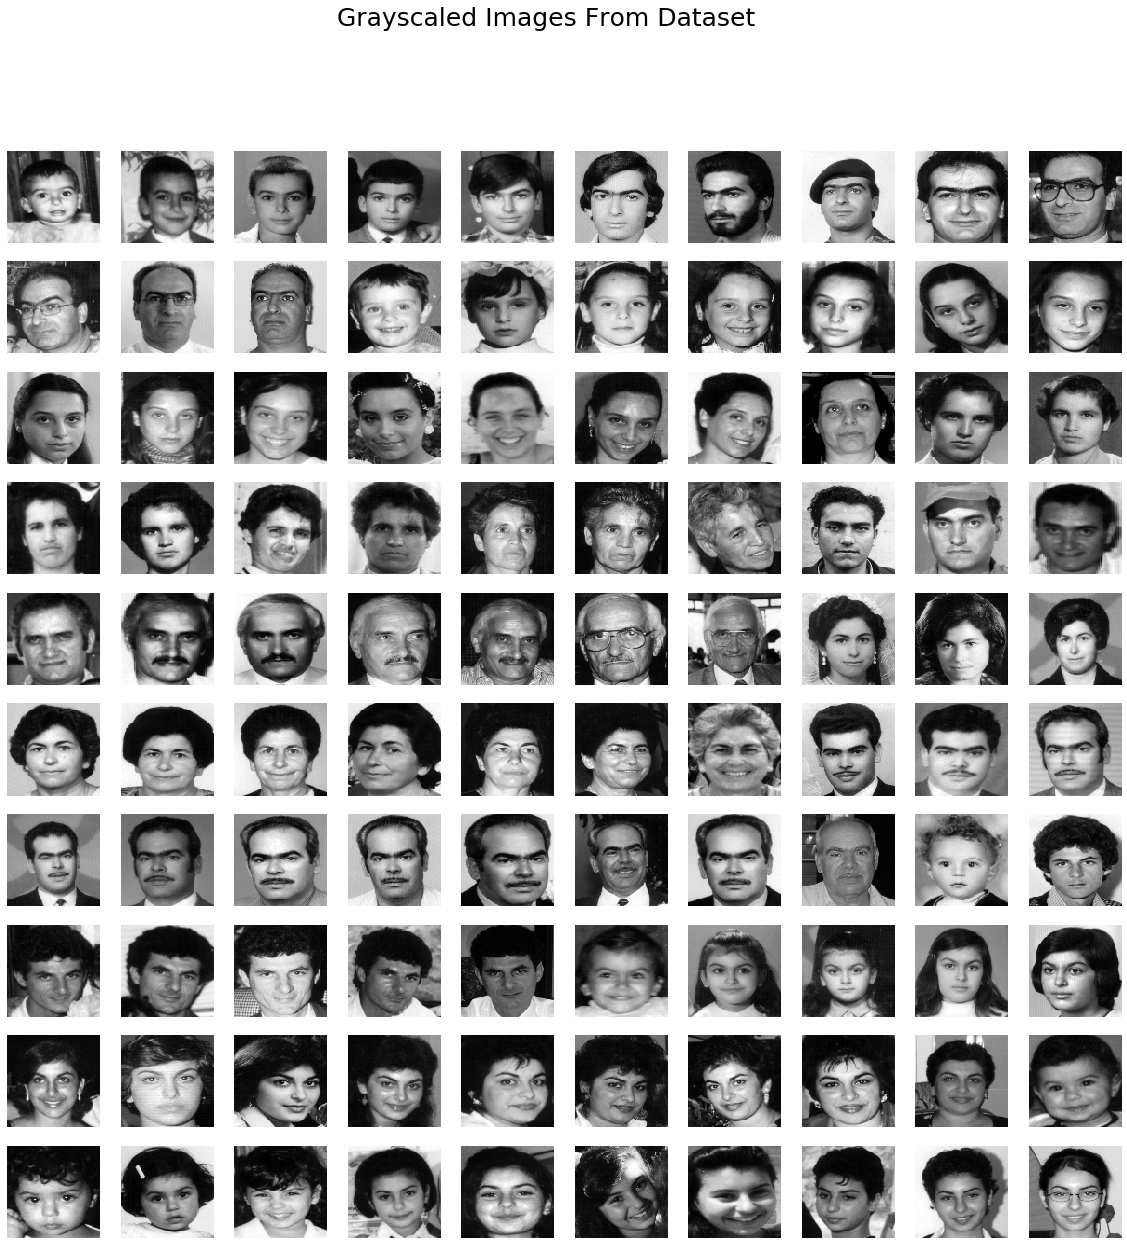

In [6]:
f,axes = plt.subplots(10,10, figsize=(20,20))
f.suptitle("Grayscaled Images From Dataset", fontsize=25)

for i,img in enumerate(axes.flat):
    
    img.imshow(images[i], cmap='gray')
    img.axis('off')

### Features

##### I printed the images side by side as grayscaled and after roberts and sobel edge detection version.

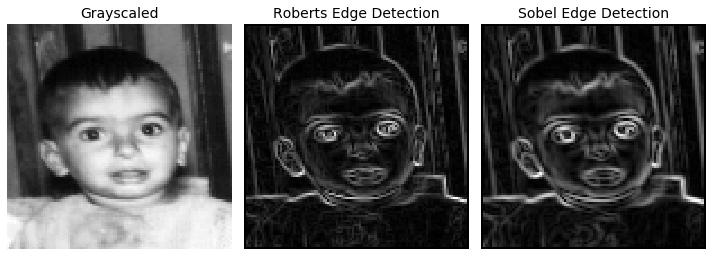

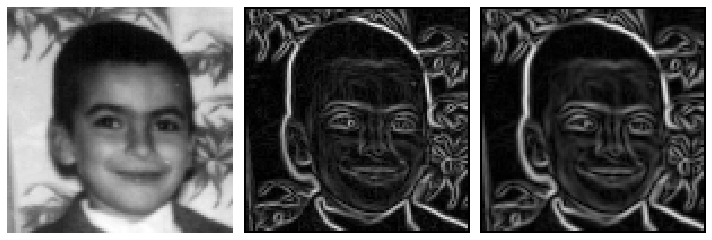

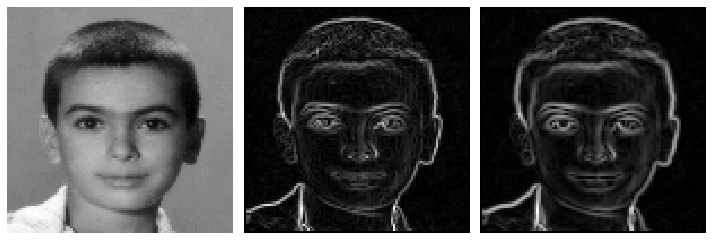

In [7]:
roberts,sobel = edge_detectors(images)

for i in range(3):
    
    fig, axes = plt.subplots(ncols=3, figsize=(10,10))
    
    if i == 0:
        
        axes[0].set_title('Grayscaled', fontsize=14)
        axes[1].set_title('Roberts Edge Detection', fontsize=14)
        axes[2].set_title('Sobel Edge Detection', fontsize=14)
    
    axes[0].imshow(images[i],cmap='gray')
    axes[1].imshow(roberts[i], cmap='gray')
    axes[2].imshow(sobel[i], cmap='gray')
    
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
images.shape

(900, 100, 100)

##### I resize all the pictures to one dimensional

In [9]:
images = images.reshape(900,10000)
roberts = roberts.reshape(900,10000)
sobel = sobel.reshape(900,10000)

## Model Implementation

### #KNNRegression Method 

In [10]:
from sklearn.base import BaseEstimator

class KNeighborsRegression(BaseEstimator):
    
    def __init__(self, n_neighbors):
        
        self.n_neighbors = n_neighbors


    def euclidean_distance(self, X1, X2):
        
        distance = np.linalg.norm(X1 - X2)
        return distance
    
    def fit(self, X, y):
        
        self.X_train = X
        self.y_train = y    
        
    def predict(self, X_test):
        
        predictions = []
                
        for i in range(len(X_test)):
            
            distances = []
            ages = [] #en yakın k tane komşunun yaşı 
            
            for j in range(len(X_train)):
                
                ed = self.euclidean_distance(X_train[j] , X_test[i])
                distances.append([ed, j])
                
            k = self.n_neighbors
            distances.sort() #en yakın distanceları almak için
            distances = distances[0:k] #verdiğimiz k değeri kadar neighbourun distanceına bakmak için
            
            for m in distances:
                age = y_train[m[1]]
                ages.append(age)

            predictions.append(sum(ages) // k)
            
        predictions = np.array(predictions)

        return predictions

### #Weighted KNNRegression Method 

In [11]:
class WeightedKNeighborsRegression(BaseEstimator):
    
    def __init__(self, n_neighbors):
        
        self.n_neighbors = n_neighbors


    def euclidean_distance(self, X1, X2):
        
        distance = np.linalg.norm(X1 - X2)
        return distance
    
    def fit(self, X, y):
        
        self.X_train = X
        self.y_train = y    
        
    def predict(self, X_test):
        
        predictions = []
                
        for i in range(len(X_test)):
            
            distances = []
            ages = [] #en yakın k tane komşunun yaşı 
            
            for j in range(len(X_train)):
                
                ed = self.euclidean_distance(X_train[j] , X_test[i])
                distances.append([ed, j])
                
            k = self.n_neighbors
            distances.sort() #en yakın distanceları almak için
            distances = distances[0:k] #verdiğimiz k değeri kadar neighbourun distanceına bakmak için
            
            for m in distances:
                age = y_train[m[1]]
                ages.append(age)
            
            age_and_distance = []
                
            for i in range(k):
                age_and_distance.append((ages[i], distances[i][0])) 

            c = 1    
            counter1 = 0
            counter2 = 0
            
            if(len(age_and_distance) != 1):
                for i in age_and_distance:
                    for j in age_and_distance:
                        if (j != i):
                            c *= j[1]
                            counter2 += c
                            counter1 += (c * i[0])
                    c = 1
                pred = int(counter1 //counter2)
            else:
                pred = int(age_and_distance[0][0])
            
            predictions.append(pred)
            
        predictions = np.array(predictions)
                
        return predictions

##### I write a function to find best n_neighbors value for my modal and after run this function I chose 8 because I got the smallest mean absolute error values at n_neighbors = 8. I removed the function from my code block because it took too long to run.

In [12]:
"""
def find_best_neighbors():
    
    for i in range(2,12):
        
        knn = KNeighborsRegression(n_neighbors = i)
        knn.fit(X_train, y_train)
        predictions1 = knn.predict(X_test)

        wknn = WeightedKNeighborsRegression(n_neighbors = i)
        wknn.fit(X_train, y_train)
        predictions2 = wknn.predict(X_test)

        cv = abs(np.mean(cross_val_score(knn, X_train, y_train, scoring= "neg_mean_absolute_error")))
        mae1 = abs(y_test - predictions1).sum() / len(y_test)    
        mae2 = abs(y_test - predictions2).sum() / len(y_test)

        print("n_neighbors =",i ,"KNN Mean Absolute Error:", mae1)
        print("n_neighbors =",i ,"Weighted KNN Mean Absolute Error:", mae2)
        print("n_neighbors =",i ,"KNN(cross_validation) Mean Absolute Error:", cv)
"""

'\ndef find_best_neighbors():\n    \n    for i in range(2,12):\n        \n        knn = KNeighborsRegression(n_neighbors = i)\n        knn.fit(X_train, y_train)\n        predictions1 = knn.predict(X_test)\n\n        wknn = WeightedKNeighborsRegression(n_neighbors = i)\n        wknn.fit(X_train, y_train)\n        predictions2 = wknn.predict(X_test)\n\n        cv = abs(np.mean(cross_val_score(knn, X_train, y_train, scoring= "neg_mean_absolute_error")))\n        mae1 = abs(y_test - predictions1).sum() / len(y_test)    \n        mae2 = abs(y_test - predictions2).sum() / len(y_test)\n\n        print("n_neighbors =",i ,"KNN Mean Absolute Error:", mae1)\n        print("n_neighbors =",i ,"Weighted KNN Mean Absolute Error:", mae2)\n        print("n_neighbors =",i ,"KNN(cross_validation) Mean Absolute Error:", cv)\n'

##### I write a small function to print mean absolute errors fastly.

In [13]:
from sklearn.model_selection import cross_val_score

def print_errors():
    
    knn = KNeighborsRegression(n_neighbors = 8)
    knn.fit(X_train, y_train)
    predictions1 = knn.predict(X_test)

    wknn = WeightedKNeighborsRegression(n_neighbors = 8)
    wknn.fit(X_train, y_train)
    predictions2 = wknn.predict(X_test)

    cv = abs(np.mean(cross_val_score(knn, X_train, y_train, scoring= "neg_mean_absolute_error")))
    mae1 = abs(y_test - predictions1).sum() / len(y_test)    
    mae2 = abs(y_test - predictions2).sum() / len(y_test)
    
    return mae1,mae2,cv

##### I print mean absolute errors for different predictions.

In [14]:
from sklearn.model_selection import train_test_split

X = roberts
y = ages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 33)

print("ROBERTS EDGE FILTER")
mae1,mae2,cv = print_errors()
print("KNN Mean Absolute Error:", mae1)
print("Weighted KNN Mean Absolute Error:", mae2)
print("KNN(cross_validation) Mean Absolute Error:", cv)
print("----------------------------------\n")
X = sobel
y = ages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 33)

print("SOBEL EDGE FILTER")
mae1,mae2,cv = print_errors()
print("KNN Mean Absolute Error:", mae1)
print("Weighted KNN Mean Absolute Error:", mae2)
print("KNN(cross_validation) Mean Absolute Error:", cv)
print("----------------------------------\n")
X = images
y = ages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 33)

print("WITHOUT FILTER")
mae1,mae2,cv = print_errors()
print("KNN Mean Absolute Error:", mae1)
print("Weighted KNN Mean Absolute Error:", mae2)
print("KNN(cross_validation) Mean Absolute Error:", cv)

ROBERTS EDGE FILTER
KNN Mean Absolute Error: 8.177777777777777
Weighted KNN Mean Absolute Error: 8.2
KNN(cross_validation) Mean Absolute Error: 8.32638888888889
----------------------------------

SOBEL EDGE FILTER
KNN Mean Absolute Error: 8.63888888888889
Weighted KNN Mean Absolute Error: 8.644444444444444
KNN(cross_validation) Mean Absolute Error: 8.48611111111111
----------------------------------

WITHOUT FILTER
KNN Mean Absolute Error: 8.455555555555556
Weighted KNN Mean Absolute Error: 8.466666666666667
KNN(cross_validation) Mean Absolute Error: 8.729166666666668


### Mean Absolute Errors

###### Roberts Edge Filter:

| KNN | Weighted KNN | KNN(cv) |
| --- | --- | --- |
| 8.18 | 8.20 | 8.33 |

###### Sobel Edge Filter:

| KNN | Weighted KNN | KNN(cv) |
| --- | --- | --- |
| 8.64 | 8.64 | 8.49 |

###### Without Filter:

| KNN | Weighted KNN | KNN(cv) |
| --- | --- | --- |
| 8.46 | 8.47 | 8.73 |

### Error Analysis

In [15]:
X = roberts
y = ages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 33)

knn = KNeighborsRegression(n_neighbors = 8)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

data = {'Ages': y_test, 'Predictions': predictions}  
pred_df = pd.DataFrame(data)

pred_df

,Ages,Predictions
0,3,11
1,5,13
2,30,17
3,33,12
4,7,15
...,...,...
175,9,11
176,29,16
177,9,22
178,25,13


My model can sometimes make very large differences between the actual ages and my predictions, and sometimes it can make accurate predictions. I think that higher percentage estimates could be made if we classified them into specific age ranges instead of making direct age estimations.

I divided my features into 3 classes as robert and sobel edge filter and only grayscaled original images and I divided my regressions into 3 classes as knn, weighted-knn and knn with cross-validation.

As a result, the sobel edge filter generally gave higher mae results than the original images. The robert edge filter and the original images generally gave close estimates, but this was also very incostant according to the n_neighbors value I gave.

I still prefer to make my predictions according to the obert edge filter for difference and choose a number of n_neighbors suitable for filter and I got 8.177 mean absolute error.

In cross validation, the values I gave to the cv parameter made a huge difference and since I didn't get mae values that were close to each other in general, I didn't want to choose a number for the cv parameter just to show a low mae score in the report, instead I left that parameter blank and preferred the program to assign a value to itself.

## Test Images

In [16]:
kaggle_images,kaggle_names =  load_images('kaggle_images')
kaggle_roberts,kaggle_sobel = edge_detectors(kaggle_images)

In [17]:
kaggle_roberts = kaggle_roberts.reshape(102,10000)

In [18]:
modal = KNeighborsRegression(n_neighbors = 8)
modal.fit(roberts, ages)
kaggle_predictions = modal.predict(kaggle_roberts)

In [19]:
kaggle_df = pd.DataFrame({"Name":kaggle_names, "Age":kaggle_predictions})
kaggle_df.head()

,Name,Age
0,1.JPG,10
1,10.JPG,18
2,100.JPG,12
3,101.JPG,15
4,102.JPG,9


In [20]:
kaggle_df.to_csv ("Kaggle_Predictions.csv", index=False, header=True)